In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2025-08-17 18:52:11.230810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755456731.406951      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755456731.468052      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
train_csv = pd.read_csv(os.path.join(BASE_PATH, "Training", "training_labels.csv"))
val_csv   = pd.read_csv(os.path.join(BASE_PATH, "Validation", "validation_labels.csv"))
test_csv  = pd.read_csv(os.path.join(BASE_PATH, "Testing", "testing_labels.csv"))

# Add full image paths
train_csv["path"] = train_csv["IMAGE"].apply(lambda x: os.path.join(BASE_PATH, "Training", "training_words", x))
val_csv["path"]   = val_csv["IMAGE"].apply(lambda x: os.path.join(BASE_PATH, "Validation", "validation_words", x))
test_csv["path"]  = test_csv["IMAGE"].apply(lambda x: os.path.join(BASE_PATH, "Testing", "testing_words", x))

# Classes = unique medicine names
class_names = sorted(train_csv["MEDICINE_NAME"].unique())
num_classes = len(class_names)
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for i, name in enumerate(class_names)}

# Encode labels
train_csv["label"] = train_csv["MEDICINE_NAME"].map(class_to_idx)
val_csv["label"]   = val_csv["MEDICINE_NAME"].map(class_to_idx)
test_csv["label"]  = test_csv["MEDICINE_NAME"].map(class_to_idx)

print("Number of classes:", num_classes)
print("Example classes:", class_names[:10])

Number of classes: 78
Example classes: ['Ace', 'Aceta', 'Alatrol', 'Amodis', 'Atrizin', 'Axodin', 'Az', 'Azithrocin', 'Azyth', 'Bacaid']


In [4]:
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)   # ensure RGB
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, tf.one_hot(label, depth=num_classes)

def make_dataset(df, training=True):
    paths = df["path"].values
    labels = df["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_csv, training=True)
val_ds   = make_dataset(val_csv, training=False)
test_ds  = make_dataset(test_csv, training=False)

I0000 00:00:1755456743.908799      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755456743.909506      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

def build_vgg16_transfer(input_shape, num_classes, dropout=0.5):
    # Load VGG16 convolutional base
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze base initially

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs, name="vgg16_transfer")

    return model

# Example usage
model = build_vgg16_transfer((*IMG_SIZE, 3), num_classes)
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 78)             │        40,01

 Total params: 23,669,134 (90.29 MB)

 Trainable params: 8,954,446 (34.16 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/50


I0000 00:00:1755456752.282851      59 service.cc:148] XLA service 0x7febcc00ff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755456752.283837      59 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755456752.283864      59 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755456752.712688      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/98 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.0174 - loss: 5.0042

I0000 00:00:1755456759.301518      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.0229 - loss: 4.5274 - val_accuracy: 0.0269 - val_loss: 4.2706
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.0386 - loss: 4.3111 - val_accuracy: 0.0859 - val_loss: 4.1385
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.0575 - loss: 4.1779 - val_accuracy: 0.1333 - val_loss: 3.9546
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.0913 - loss: 4.0005 - val_accuracy: 0.2269 - val_loss: 3.6628
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1386 - loss: 3.7679 - val_accuracy: 0.2500 - val_loss: 3.3672
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.1808 - loss: 3.4790 - val_accuracy: 0.3192 - val_loss: 3.0393
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.2353 - loss: 3.1685 - val_accuracy: 0.4487 - val_loss: 2.6627
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.2830 - loss: 2.9431 - val_accuracy: 0.4718 - val_loss: 

In [7]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7974 - loss: 0.8907
Test accuracy: 0.7461538314819336


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


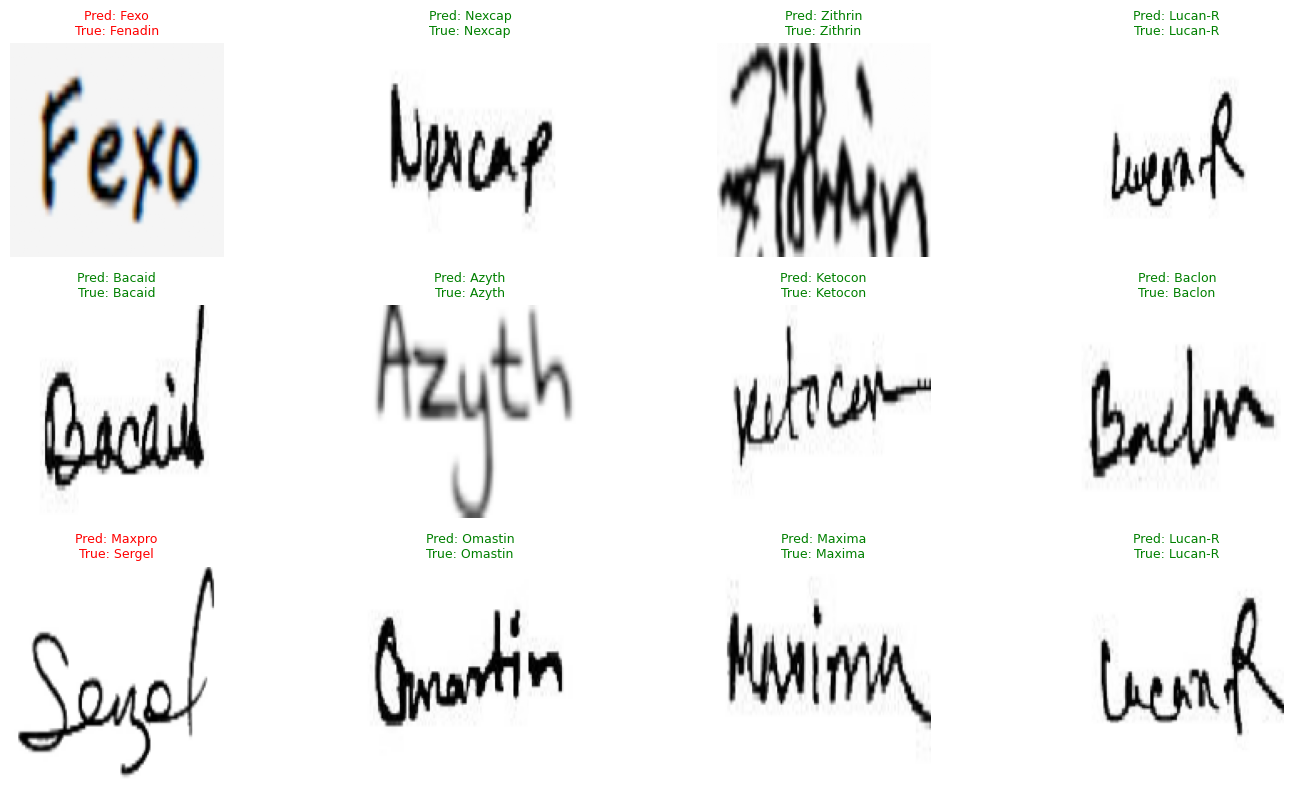

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get all test images and labels as numpy arrays
all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Randomly choose 12 indices
num_samples = 12
indices = np.random.choice(len(all_images), num_samples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    img = all_images[idx]
    label = all_labels[idx]

    pred = model.predict(img[np.newaxis, ...])
    pred_class = np.argmax(pred, axis=1)[0]
    true_class = np.argmax(label)

    pred_label = idx_to_class[pred_class]
    true_label = idx_to_class[true_class]
    color = "green" if pred_label == true_label else "red"

    ax = plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()
